In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


c:\Users\ssupa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse


In [2]:
class PMDataset(Dataset):
    def __init__(self, values, target_idx, window_size=7):
        self.X, self.y = [], []
        for i in range(len(values) - window_size):
            self.X.append(values[i:i+window_size])
            self.y.append(values[i+window_size, target_idx])
        
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM

In [3]:
import torch.nn as nn

class PM25_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # last timestep
        return self.fc(out)


   PM2.5_lag1  dayofyear_cos   Pres.  Humi.   Vis.  Wind Speed  \
0        11.0      -0.183998  1008.3   79.7  17780         4.8   
1         9.0      -0.200891  1007.6   79.5  19379         5.0   
2         9.0      -0.217723  1007.9   77.7  19031         3.7   
3         8.0      -0.234491  1009.2   74.8  18168         3.6   
4        16.0      -0.251190  1011.4   93.6  11702         3.1   

   PM2.5_rollmean14  dayofyear_sin  heatidx  Prec._rollsum14  PM2.5_lag3  \
0         24.333333       0.982927     39.2              0.0        43.0   
1         20.500000       0.979614     39.4              0.0        19.0   
2         18.200000       0.976011     38.6              0.0        11.0   
3         16.500000       0.972118     38.6              0.0         9.0   
4         16.428571       0.967938     26.8              0.0         9.0   

      month_cos  Prec._rollmean14  Prec._rollmean7  Prec._rollsum7  \
0  6.123234e-17               0.0              0.0             0.0   
1  6.1

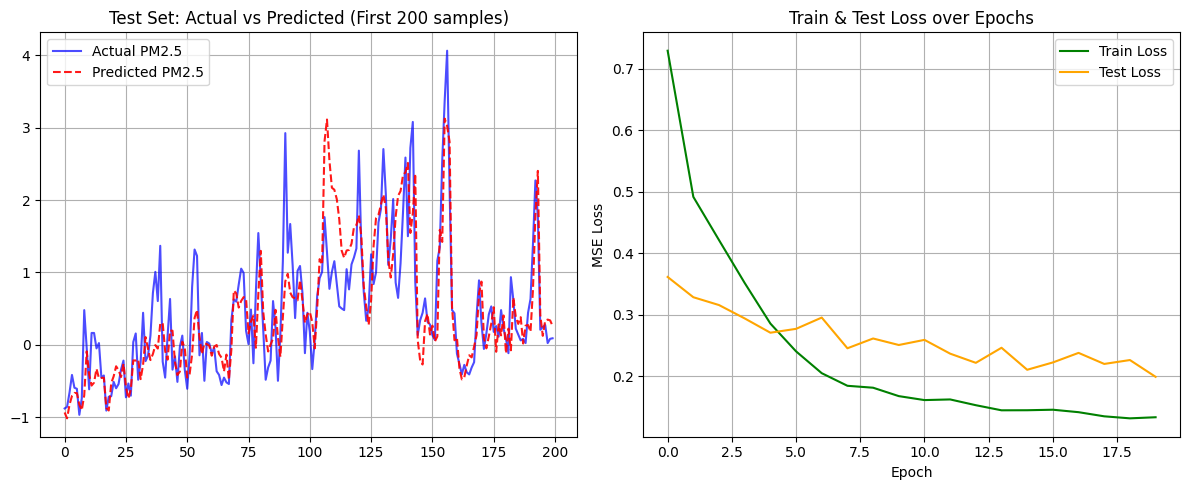

In [5]:
# 2. เตรียมข้อมูลและแบ่ง Train/Test
df = pd.read_csv("cleaned_features.csv")

# เลือกเฉพาะ features ที่สำคัญ + target
selected_features = [
    'PM2.5_lag1',
    'dayofyear_cos',
    'Pres.',
    'Humi.',
    'Vis.',
    'Wind Speed',
    'PM2.5_rollmean14',
    'dayofyear_sin',
    'heatidx',
    'Prec._rollsum14',
    'PM2.5_lag3',
    'month_cos',
    'Prec._rollmean14',
    'Prec._rollmean7',
    'Prec._rollsum7',
    'Wind Dir_cos',
    'Wind Dir_sin',
    'PM2.5',  # target
]

num_df = df[selected_features].dropna().reset_index(drop=True)

train_size = int(len(num_df) * 0.8)
train_df = num_df.iloc[:train_size].copy()
print(train_df.head())
test_df = num_df.iloc[train_size:].copy()

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

target_idx = num_df.columns.get_loc('PM2.5')
window_size = 30

train_dataset = PMDataset(train_scaled, target_idx, window_size)
test_dataset = PMDataset(test_scaled, target_idx, window_size)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
print(f"Features: {num_df.shape[1]-1}, Samples: {len(num_df)}")
# Test loader ไม่ต้อง shuffle เพื่อให้ plot กราฟตามลำดับเวลาได้
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# 3. Model
model = PM25_LSTM(input_size=num_df.shape[1], hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop with evaluation each epoch
EPOCHS = 20
train_losses = []
test_losses_per_epoch = []

for epoch in range(EPOCHS):
    # --- Train ---
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Evaluate on test set each epoch ---
    model.eval()
    test_epoch_loss = 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            preds = model(X_test)
            loss = criterion(preds, y_test)
            test_epoch_loss += loss.item()
    avg_test_loss = test_epoch_loss / len(test_loader)
    test_losses_per_epoch.append(avg_test_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

# 5. Final Evaluation & Plotting
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for X_test, y_test in test_loader:
        preds = model(X_test)
        all_preds.extend(preds.numpy())
        all_actuals.extend(y_test.numpy())

test_r2 = r2_score(all_actuals, all_preds)
print(f"\nTest R² Score: {test_r2:.4f}")

# Plot กราฟ
plt.figure(figsize=(12, 5))

# กราฟเปรียบเทียบค่าจริง vs ค่าทำนาย
plt.subplot(1, 2, 1)
plt.plot(all_actuals[:200], label='Actual PM2.5', color='blue', alpha=0.7)
plt.plot(all_preds[:200], label='Predicted PM2.5', color='red', linestyle='--', alpha=0.9)
plt.title('Test Set: Actual vs Predicted (First 200 samples)')
plt.legend()
plt.grid(True)

# กราฟ Train & Test Loss รวมกัน
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(test_losses_per_epoch, label='Test Loss', color='orange')
plt.title('Train & Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()